In [2]:
import pandas as pd
import json
from torch import cuda
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, DebertaTokenizerFast
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import ast
from transformers import Trainer
from transformers import TrainingArguments
from docx import Document
from docx.shared import RGBColor
from transformers import DataCollatorForTokenClassification
from sklearn.model_selection import KFold
import os

/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
label2id = {'O': 0,
 'I-Treatment': 1,
 'I-Test': 2,
 'I-Problem': 3,
 'I-Background': 4,
 'I-Other': 5}
id2label = {id: tag for tag, id in label2id.items()}

# Print the dictionaries
print("label2id:", label2id)
print("id2label:", id2label)

label2id: {'O': 0, 'I-Treatment': 1, 'I-Test': 2, 'I-Problem': 3, 'I-Background': 4, 'I-Other': 5}
id2label: {0: 'O', 1: 'I-Treatment', 2: 'I-Test', 3: 'I-Problem', 4: 'I-Background', 5: 'I-Other'}


In [5]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)
# device = 'cuda:1' if cuda.is_available() and cuda.device_count() > 1 else 'cpu'
# print(device)

cuda


In [6]:
def transform(example_batch):
    example_batch['sentence'] = ast.literal_eval(example_batch['sentence'])
    example_batch['tag'] = ast.literal_eval(example_batch['tag'])
    example_batch['tag'] = [label2id[label] for label in example_batch['tag']]
    return example_batch

def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            new_labels.append(label)

    return new_labels

def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(
        examples["sentence"], truncation=True, is_split_into_words=True
    )
    
    all_labels = examples["tag"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

def tokenize_and_align_labels_wrapper(examples, tokenizer):
    return tokenize_and_align_labels(examples, tokenizer)

def untokenize_labels_predictions(word_ids, true_labels, predictions):
    untokenized_true_labels = []
    untokenized_predictions = []

    for sublist_word_ids, sublist_true_labels, sublist_predictions in zip(word_ids, true_labels, predictions):
        current_labels = []
        current_predictions = []
        last_word_id = None

        for word_id, label, prediction in zip(sublist_word_ids[1:-1], sublist_true_labels, sublist_predictions):
            # Skip if this word_id is the same as the last one (it's a subword)
            if word_id == last_word_id:
                continue

            current_labels.append(label)
            current_predictions.append(prediction)
            last_word_id = word_id

        untokenized_true_labels.append(current_labels)
        untokenized_predictions.append(current_predictions)

    return untokenized_true_labels, untokenized_predictions

class TrainingMonitor:
    def __init__(self):
        self.best_f1 = 0
        self.best_confusion_matrix = None

    def compute_metrics_factory(self, word_ids, fold_no, eval_dataset_name, model_name):
        # Define the actual compute_metrics function
        def compute_metrics(eval_preds):
            logits, labels = eval_preds
            predictions = np.argmax(logits, axis=-1)

            # Remove ignored index (special tokens) and convert to labels
            true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
            true_predictions = [
                [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
                for prediction, label in zip(predictions, labels)
            ]

            untokenized_true_labels, untokenized_predictions = untokenize_labels_predictions(word_ids, true_labels, true_predictions)

            unflat_true = [label for seq in untokenized_true_labels for label in seq]
            unflat_pred = [label for seq in untokenized_predictions for label in seq]
            unreport = classification_report(y_pred=unflat_pred, y_true=unflat_true, output_dict=True)
            unreport['macro_wo_O'] = {'precision': (unreport['I-Background']['precision'] + unreport['I-Other']['precision'] + unreport['I-Problem']['precision'] + unreport['I-Test']['precision'] + unreport['I-Treatment']['precision']) / 5,
            'recall': (unreport['I-Background']['recall'] + unreport['I-Other']['recall'] + unreport['I-Problem']['recall'] + unreport['I-Test']['recall'] + unreport['I-Treatment']['recall']) / 5,
            'f1-score': (unreport['I-Background']['f1-score'] + unreport['I-Other']['f1-score'] + unreport['I-Problem']['f1-score'] + unreport['I-Test']['f1-score'] + unreport['I-Treatment']['f1-score']) / 5,
            'support': (unreport['I-Background']['support'] + unreport['I-Other']['support'] + unreport['I-Problem']['support'] + unreport['I-Test']['support'] + unreport['I-Treatment']['support'])}
            
            un_report_df = pd.DataFrame(unreport).round(3).T

            new_f1_score = unreport['macro_wo_O']['f1-score']
            if self.best_f1 < new_f1_score:
                self.best_f1 = new_f1_score
                cm = confusion_matrix(y_pred=unflat_pred, y_true=unflat_true)
                disp = ConfusionMatrixDisplay(cm, display_labels=np.array(['I-Background','I-Other', 'I-Problem', 'I-Test', 'I-Treatment', 'O']))
                fig, ax = plt.subplots(figsize=(8, 8))
                disp.plot(ax=ax)

               
                binary_predictions = ['0' if label == 'O' else '1' for label in unflat_pred]
                binary_labels = ['0' if label == 'O' else '1' for label in unflat_true]

                # Generate a classification report
                binary_classification_report = classification_report(y_true=binary_labels, y_pred=binary_predictions, target_names=['O', 'I'], digits=3, output_dict=True)

                # Define the directory paths
                graph_dir = f'analysis/{model_name}/{eval_dataset_name}/graphs/fold{fold_no}'
                report_dir = f'analysis/{model_name}/{eval_dataset_name}/reports/fold{fold_no}'

                # Create directories if they do not exist
                os.makedirs(graph_dir, exist_ok=True)
                os.makedirs(report_dir, exist_ok=True)

                # Save the confusion matrix as a PNG file
                plt.savefig(f'{graph_dir}/confusion_matrix.png')
                plt.close()

                # Save the multiclass classification report as a JSON file
                with open(f"{report_dir}/multiclass_classification_report.json", "w") as f:
                    json.dump(un_report_df.to_dict(), f, indent=4)

                # Save the binary classification report as a JSON file
                with open(f"{report_dir}/binary_classification_report.json", "w") as f:
                    json.dump(binary_classification_report, f, indent=4)
                

            return {
                "precision": unreport['macro avg']['precision'],
                "recall": unreport['macro avg']['recall'],
                "f1": unreport['macro avg']['f1-score'],
                "accuracy": unreport['accuracy'],
            }
        return compute_metrics


In [7]:
model_names = ['bertclinical-ft'] #['biobert-ft','scibert-ft', 'bluebert-ft', 'bert-ft', 'bertclinical-ft', 'bioclinicalbert-ft', 'deberta-ft']
model_checkpoints = [ 'samrawal/bert-base-uncased_clinical-ner'] #['monologg/biobert_v1.1_pubmed', 'allenai/scibert_scivocab_uncased', 'bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16', 'google-bert/bert-base-uncased', 'samrawal/bert-base-uncased_clinical-ner' ,'emilyalsentzer/Bio_ClinicalBERT', 'microsoft/deberta-base']
for model_name, model_checkpoint in zip(model_names, model_checkpoints):

    # model_name = 'bert-ft'
    # model_checkpoint = 'bert-base-uncased' #'allenai/scibert_scivocab_uncased' #'bert-base-uncased' #'bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16' # samrawal/bert-base-uncased_clinical-ner
    if model_name == 'deberta-ft':
        tokenizer = DebertaTokenizerFast.from_pretrained(model_checkpoint, add_prefix_space=True)
    else:
        tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

    dataset_name = 'phee'
    eval_dataset_name = 'mtsamples2'
    for i in range(0, 1):
        dataset = load_dataset('csv', data_files={'train': f'data/processed/{dataset_name}/fold{i}/combined.csv', 'test': f'data/processed/{eval_dataset_name}/mtsamples200.csv'})
        for file_type in ['train', 'test']:
            dataset[file_type] = dataset[file_type].map(transform)


        tokenized_datasets = dataset.map(
        lambda examples: tokenize_and_align_labels_wrapper(examples, tokenizer),
        batched=True,
        remove_columns=dataset['train'].column_names)

        # word ids of the tokenized test set to find the original words
        test_sentences = dataset['test']['sentence']
        test_word_ids = []
        for sentence in test_sentences:
            test_word_ids.append(tokenizer(sentence, truncation=True, is_split_into_words=True).word_ids())

        model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint,
        # 'samrawal/bert-base-uncased_clinical-ner',
        # 'microsoft/deberta-base',
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
        )
        
        # Then, when setting up your Trainer:
        monitor = TrainingMonitor()

        args = TrainingArguments(
        f"models/{model_name}/fold{i}",
        # f"models/deberta-finetuned-ner/fold{i}",
        overwrite_output_dir=True,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        evaluation_strategy="no",
        save_strategy="no",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        learning_rate=1e-5,
        num_train_epochs=5,
        logging_strategy="epoch",
        )   

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=tokenized_datasets['train'],
            eval_dataset=tokenized_datasets['test'],
            data_collator=data_collator,
            compute_metrics=monitor.compute_metrics_factory(test_word_ids, fold_no=i, eval_dataset_name=eval_dataset_name, model_name=model_name),
            tokenizer=tokenizer,
        )
        trainer.train()
        # print("Save model to:", f'models/{model_name}/fold{i}')
        # model.save_pretrained(f'models/{model_name}/fold{i}')
        # tokenizer.save_pretrained(f'models/{model_name}/fold{i}')

        trainer.evaluate(eval_dataset=tokenized_datasets['test'])

 
    

Map:   0%|          | 0/197 [00:00<?, ? examples/s]

/home/ozan/anaconda3/envs/lara-medh/lib/python3.12/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at samrawal/bert-base-uncased_clinical-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the

Step,Training Loss
1178,0.375200
2356,0.237000
3534,0.184600
4712,0.144100
5890,0.124800


In [43]:
import shutil
# Define the paths
reports_base_path = f'analysis/{model_name}/{dataset_name}/reports/'
models_base_path = f'models/{model_name}'
folds = [f'fold{i}' for i in range(5)]

# Initialize variables to track the best model
best_f1_score = -1
best_fold = None

# Iterate over each fold to find the best model
for fold in folds:
    report_path = os.path.join(reports_base_path, fold, 'multiclass_classification_report.json')
    if os.path.exists(report_path):
        with open(report_path, 'r') as file:
            report = json.load(file)
            f1_score_macro_wo_O = report['f1-score']['macro_wo_O']
            if f1_score_macro_wo_O > best_f1_score:
                best_f1_score = f1_score_macro_wo_O
                best_fold = fold

# Delete the models of other folds
for fold in folds:
    if fold != best_fold:
        model_path = os.path.join(models_base_path, fold)
        shutil.rmtree(model_path)

best_fold, best_f1_score



('fold3', 0.807)

## Evaluate on mtsamples

In [32]:
from scipy.special import softmax

# from seqeval.scheme import IOB2
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
# from seqeval.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [33]:
def transformm(example_batch):
    example_batch['sentence'] = ast.literal_eval(example_batch['sentence'])

    example_batch['tag'] = ast.literal_eval(example_batch['tag'])
 
    example_batch['tag'] = [label2id[label] for label in example_batch['tag']]
    return example_batch

In [71]:
from docx import Document
from docx.oxml.ns import qn
from docx.oxml import OxmlElement
def blend_with_white(hex_color, score):
    """Blend color with white based on the score."""
    # Ensure score is between 0 and 1
    score = max(0, min(1, score))
    # Convert hex color to RGB
    r, g, b = int(hex_color[:2], 16), int(hex_color[2:4], 16), int(hex_color[4:], 16)
    # Blend with white
    white_blend = lambda d: int(d + (255 - d) * (1 - score))
    return f"{white_blend(r):02X}{white_blend(g):02X}{white_blend(b):02X}"

def highlight_false_positives_to_docx(sentences, predictions, labels, y_scores, file_path):
    doc = Document()
    if len(sentences) != len(predictions) != len(labels):
        raise ValueError("Number of sentences, predictions and labels must be the same")
    for sentence, pred_tags, true_tags, y_score in zip(sentences, predictions, labels, y_scores):
        p = doc.add_paragraph()
        for word, pred_tag, true_tag, score in zip(sentence, pred_tags, true_tags, y_score):
            run = p.add_run(word + ' ')

            # print(word, pred_tag, true_tag)
            # If the prediction is wrong, make the word bold
            if pred_tag != true_tag:
                run.font.bold = True

            # Apply color coding based on the prediction
            color = None
            if pred_tag == "I-Problem":
                color = 'FDFD96' # yellow                      #'FF00FF'  # Pink
            elif pred_tag == "I-Treatment":
                color = '87CEEB'#'0000FF'  # blue
            elif pred_tag == "I-Other":
                color = 'FFB6C1' # pink                         #'FF0000'  # Red
            elif pred_tag == "I-Background":
                color = 'D3D3D3'  # Gray_25
            elif pred_tag == "I-Test":
                color = '90EE90'#'00FF00' # green
                
            # if color:
            #     rPr = run._element.get_or_add_rPr()
            #     shading_elm = OxmlElement('w:shd')
            #     shading_elm.set(qn('w:fill'), color)
            #     rPr.append(shading_elm)

            if color:
                blended_color = blend_with_white(color, score)
                rPr = run._element.get_or_add_rPr()
                shading_elm = OxmlElement('w:shd')
                shading_elm.set(qn('w:fill'), blended_color)
                rPr.append(shading_elm)

    doc.save(file_path)

def compute_metricss_factory(eval_word_ids, fold_no, eval_dataset_name):
    def compute_metricss(eval_preds):
        plt.ioff()
        logits, labels = eval_preds
        predictions = np.argmax(logits, axis=-1)
        scores = softmax(logits, axis=-1)

        # Remove ignored index (special tokens) and convert to labels
        true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
        true_predictions = [
            [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        y_true = [[0 if l == 0 else 1 for l in label if l != -100] for label in labels]
        y_scores_list = [[sum(s[1:]) for (s, l) in zip(score, label) if l != -100]
            for score, label in zip(scores, labels)] # list of lists
        y_true = [item for sublist in y_true for item in sublist]
        y_scores = [item for sublist in y_scores_list for item in sublist]
        
        # `y_true` should be your binary true labels (0 for 'O', 1 for not 'O')
        # `y_scores` should be the binary scores you've computed as shown above

        # Calculate ROC Curve and AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Calculate Precision-Recall Curve and AUC
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        pr_auc = auc(recall, precision)

        # Plot ROC Curve
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, color='blue', lw=2, marker='.', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.savefig(f'analysis/{eval_dataset_name}/graphs/fold{fold_no}/roc-curve.png')

        # Plot Precision-Recall Curve
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
    
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")

        plt.tight_layout()
        plt.savefig(f'analysis/{eval_dataset_name}/graphs/fold{fold_no}/precision-recall-curve.png')

    

        untokenized_true_labels, untokenized_predictions = untokenize_labels_predictions(eval_word_ids, true_labels, true_predictions)
    
        
        # flat_true = [label for seq in true_labels for label in seq]
        # flat_pred = [label for seq in true_predictions for label in seq]
        # report = classification_report(y_pred=flat_pred, y_true=flat_true, output_dict=True)
        # report['macro_wo_O'] = {'precision': (report['I-Background']['precision'] + report['I-Other']['precision'] + report['I-Problem']['precision'] + report['I-Test']['precision'] + report['I-Treatment']['precision']) / 5,
        # 'recall': (report['I-Background']['recall'] + report['I-Other']['recall'] + report['I-Problem']['recall'] + report['I-Test']['recall'] + report['I-Treatment']['recall']) / 5,
        # 'f1-score': (report['I-Background']['f1-score'] + report['I-Other']['f1-score'] + report['I-Problem']['f1-score'] + report['I-Test']['f1-score'] + report['I-Treatment']['f1-score']) / 5,
        # 'support': (report['I-Background']['support'] + report['I-Other']['support'] + report['I-Problem']['support'] + report['I-Test']['support'] + report['I-Treatment']['support'])}
        
        # report_df = pd.DataFrame(report).round(3).T


        unflat_true = [label for seq in untokenized_true_labels for label in seq]
        unflat_pred = [label for seq in untokenized_predictions for label in seq]
        unreport = classification_report(y_pred=unflat_pred, y_true=unflat_true, output_dict=True)
        unreport['macro_wo_O'] = {'precision': (unreport['I-Background']['precision'] + unreport['I-Other']['precision'] + unreport['I-Problem']['precision'] + unreport['I-Test']['precision'] + unreport['I-Treatment']['precision']) / 5,
        'recall': (unreport['I-Background']['recall'] + unreport['I-Other']['recall'] + unreport['I-Problem']['recall'] + unreport['I-Test']['recall'] + unreport['I-Treatment']['recall']) / 5,
        'f1-score': (unreport['I-Background']['f1-score'] + unreport['I-Other']['f1-score'] + unreport['I-Problem']['f1-score'] + unreport['I-Test']['f1-score'] + unreport['I-Treatment']['f1-score']) / 5,
        'support': (unreport['I-Background']['support'] + unreport['I-Other']['support'] + unreport['I-Problem']['support'] + unreport['I-Test']['support'] + unreport['I-Treatment']['support'])}
        
        un_report_df = pd.DataFrame(unreport).round(3).T

        binary_predictions = ['0' if label == 'O' else '1' for label in unflat_pred]
        binary_labels = ['0' if label == 'O' else '1' for label in unflat_true]

        # Generate a classification report
        binary_classification_report = classification_report(y_true=binary_labels, y_pred=binary_predictions, target_names=['O', 'I'], digits=3,  output_dict=True)
        

    

        cm = confusion_matrix(y_pred=unflat_pred, y_true=unflat_true)
        disp = ConfusionMatrixDisplay(cm, display_labels=np.array(['Background','Other', 'Problem', 'Test', 'Treatment', 'O']))
        fig, ax = plt.subplots(figsize=(10, 10))
        disp.plot(ax=ax)

        # Save the figure to an image file
        plt.savefig(f'analysis/{eval_dataset_name}/graphs/fold{fold_no}/confusion_matrix.png')

     

    
        with open(f"analysis/{eval_dataset_name}/reports/fold{fold_no}/multiclass_classification_report.json", "w") as f:
            json.dump(un_report_df.to_dict(), f, indent=4)

        with open(f"analysis/{eval_dataset_name}/reports/fold{fold_no}/binary_classification_report.json", "w") as f:
            json.dump(binary_classification_report, f, indent=4)
      
    
        
        # highlight fp
        highlight_false_positives_to_docx(eval_df['sentence'], untokenized_predictions, untokenized_true_labels,  y_scores_list, f'analysis/{eval_dataset_name}/reports/fold{fold_no}/highlighted_false_positives.docx')

        # Calculate metrics using seqeval
        return {
            "f1": f1_score(true_labels, true_predictions),
            "precision": precision_score(true_labels, true_predictions),
            "recall": recall_score(true_labels, true_predictions),
            # Add the confusion matrix 
            
        }
    return compute_metricss



In [72]:
for fold_no in range(5):  
    # Load the evaluation data
    eval_dataset = load_dataset('csv', data_files=f'data/processed/{eval_dataset_name}/final_eval.csv')
    eval_dataset = eval_dataset.map(transformm)
    
    # word ids of the tokenized mtsamples to find the original words
    eval_sentences = eval_dataset['train']['sentence']
    eval_word_ids = []
    for sentence in eval_sentences:
        eval_word_ids.append(tokenizer(sentence, truncation=True, is_split_into_words=True).word_ids())

    # Load the tokenizer
    checkpoint_path = f'models/bert-finetuned-ner/fold{fold_no}/checkpoint-2355'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

    # Load the model
    model = AutoModelForTokenClassification.from_pretrained(checkpoint_path)

    # Prepare the evaluation dataset
    eval_dataset = eval_dataset.map(lambda examples: tokenize_and_align_labels_wrapper(examples, tokenizer), batched=True, remove_columns=eval_dataset['train'].column_names)



    # Define the training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        do_predict=True,
        per_device_eval_batch_size=4
    )

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        compute_metrics=compute_metricss_factory(eval_word_ids, fold_no, eval_dataset_name=eval_dataset_name),
    )

    # Evaluate the model
    results = trainer.evaluate(eval_dataset['train'])
    print(results)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'eval_loss': 0.3243022859096527, 'eval_f1': 0.6813880126182965, 'eval_precision': 0.6997840172786177, 'eval_recall': 0.6639344262295082, 'eval_runtime': 1.7558, 'eval_samples_per_second': 57.523, 'eval_steps_per_second': 7.404}


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'eval_loss': 0.3131695091724396, 'eval_f1': 0.6967471143756558, 'eval_precision': 0.7139784946236559, 'eval_recall': 0.680327868852459, 'eval_runtime': 1.9679, 'eval_samples_per_second': 51.323, 'eval_steps_per_second': 6.606}


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'eval_loss': 0.3233713209629059, 'eval_f1': 0.6863157894736842, 'eval_precision': 0.7056277056277056, 'eval_recall': 0.6680327868852459, 'eval_runtime': 1.9767, 'eval_samples_per_second': 51.095, 'eval_steps_per_second': 6.577}


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'eval_loss': 0.31071045994758606, 'eval_f1': 0.6945606694560669, 'eval_precision': 0.7094017094017094, 'eval_recall': 0.680327868852459, 'eval_runtime': 1.998, 'eval_samples_per_second': 50.55, 'eval_steps_per_second': 6.506}


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.3090122938156128, 'eval_f1': 0.7040498442367602, 'eval_precision': 0.7136842105263158, 'eval_recall': 0.694672131147541, 'eval_runtime': 1.7519, 'eval_samples_per_second': 57.651, 'eval_steps_per_second': 7.42}


In [70]:
eval_dataset['train'][43]

{'input_ids': [101,
  5776,
  5281,
  1037,
  2309,
  2792,
  1997,
  2010,
  4432,
  16922,
  1012,
  2076,
  1996,
  2792,
  1010,
  2002,
  2371,
  19029,
  3064,
  1998,
  4298,
  2422,
  4974,
  2098,
  1012,
  2010,
  2564,
  2001,
  2556,
  1998,
  3264,
  2008,
  2002,
  2246,
  5186,
  5122,
  1012,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [-100,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  0,
  0,
  3,
  3,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  3,
  0,
  -100]}

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.339800,1.181378,0.197947,0.272324,0.226435,0.605713
2,1.058400,0.990710,0.532422,0.348553,0.375845,0.675154
3,0.876100,0.838394,0.557929,0.446716,0.474234,0.780642
4,0.760200,0.756434,0.561631,0.479922,0.500287,0.805911
5,0.681900,0.707588,0.567452,0.480763,0.505064,0.809461
6,0.627900,0.680360,0.565721,0.493492,0.512536,0.814259
7,0.588400,0.646212,0.567279,0.498393,0.518990,0.820177
8,0.559500,0.630567,0.567509,0.502759,0.521337,0.823439
9,0.539700,0.620765,0.570573,0.499448,0.520039,0.823887
10,0.528000,0.615156,0.569660,0.502995,0.522330,0.825262


/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ozan/.cond

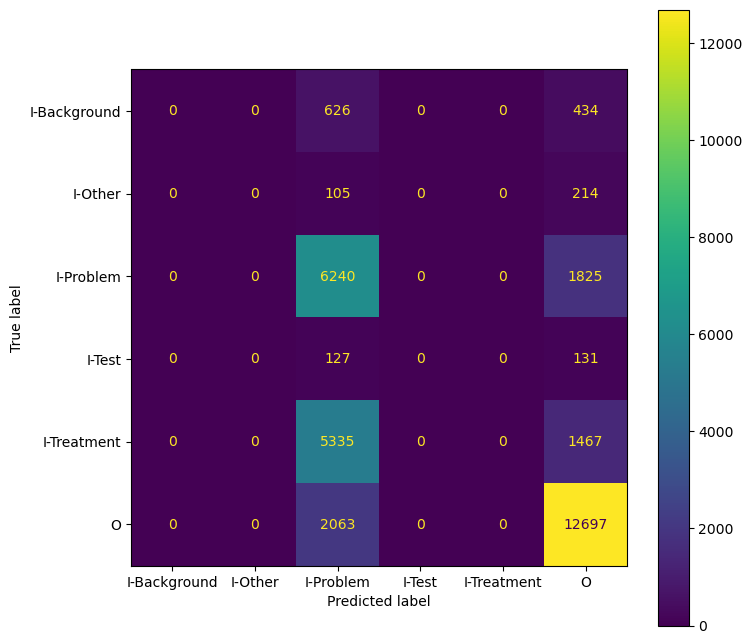

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.000   0.000     0.000   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.430   0.774     0.553   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.000   0.000     0.000   6802.000
O                 0.757   0.860     0.805  14760.000
accuracy          0.606   0.606     0.606      0.606
macro avg         0.198   0.272     0.226  31264.000
weighted avg      0.469   0.606     0.523  31264.000
macro_wo_O        0.086   0.155     0.111  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.000   0.000     0.000    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.407   0.634     0.496   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.000   0.000     0.000   2875.00
O                 0.788   0.916     0.847  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

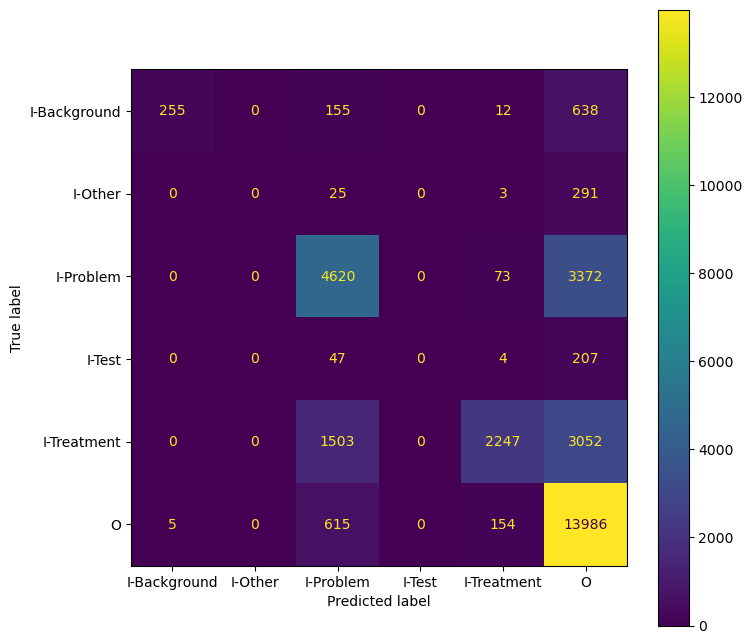

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.981   0.241     0.386   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.663   0.573     0.615   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.901   0.330     0.483   6802.000
O                 0.649   0.948     0.770  14760.000
accuracy          0.675   0.675     0.675      0.675
macro avg         0.532   0.349     0.376  31264.000
weighted avg      0.707   0.675     0.641  31264.000
macro_wo_O        0.509   0.229     0.297  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.981   0.258     0.408    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.663   0.435     0.526   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.894   0.203     0.331   2875.000
O                 0.719   0.977     0.829  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

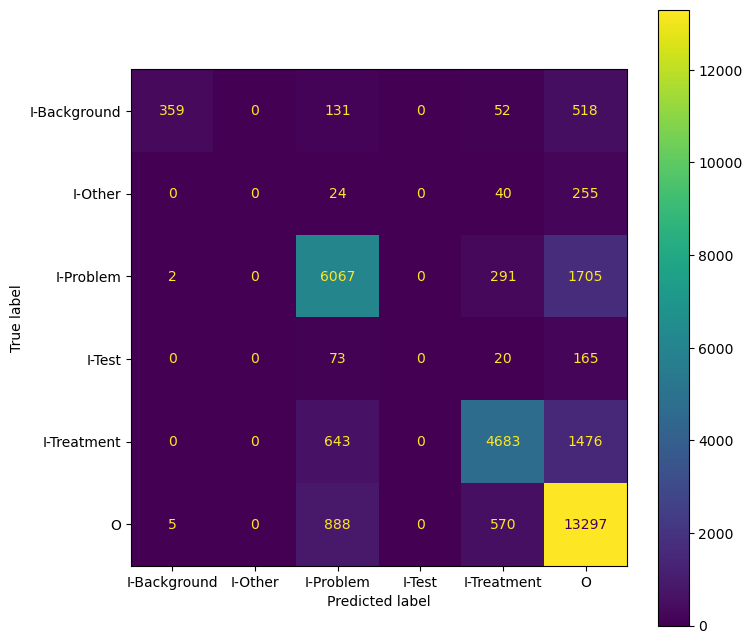

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.981   0.339     0.504   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.775   0.752     0.764   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.828   0.688     0.752   6802.000
O                 0.763   0.901     0.827  14760.000
accuracy          0.781   0.781     0.781      0.781
macro avg         0.558   0.447     0.474  31264.000
weighted avg      0.774   0.781     0.768  31264.000
macro_wo_O        0.517   0.356     0.404  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.981   0.362     0.529    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.756   0.629     0.687   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.783   0.555     0.650   2875.00
O                 0.794   0.950     0.865  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

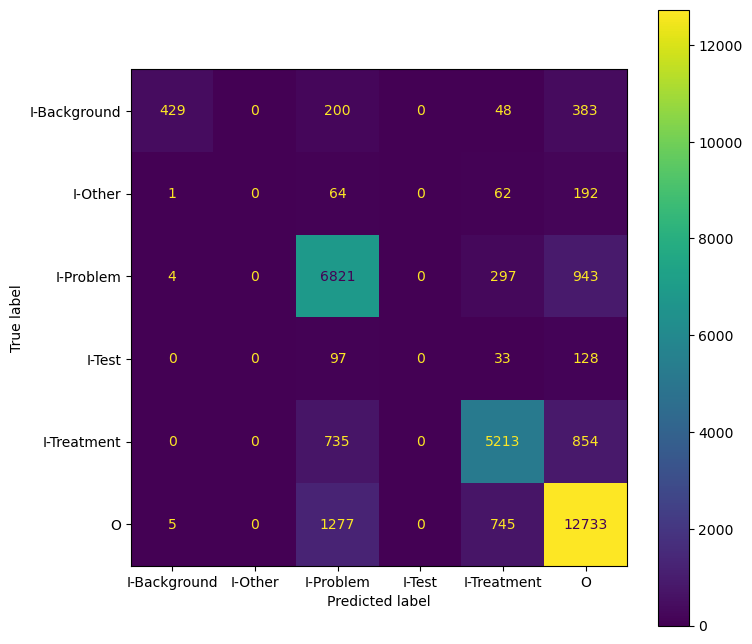

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.977   0.405     0.572   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.742   0.846     0.790   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.815   0.766     0.790   6802.000
O                 0.836   0.863     0.849  14760.000
accuracy          0.806   0.806     0.806      0.806
macro avg         0.562   0.480     0.500  31264.000
weighted avg      0.796   0.806     0.796  31264.000
macro_wo_O        0.507   0.403     0.431  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.979   0.432     0.600    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.704   0.766     0.734   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.757   0.660     0.705   2875.000
O                 0.851   0.920     0.884  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

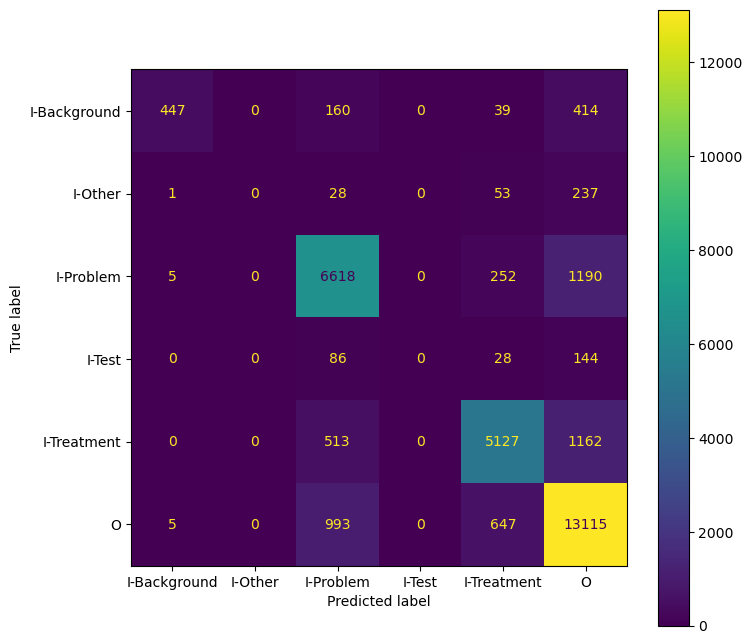

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.976   0.422     0.589   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.788   0.821     0.804   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.834   0.754     0.792   6802.000
O                 0.806   0.889     0.846  14760.000
accuracy          0.809   0.809     0.809      0.809
macro avg         0.567   0.481     0.505  31264.000
weighted avg      0.799   0.809     0.799  31264.000
macro_wo_O        0.520   0.399     0.437  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.978   0.451     0.617    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.762   0.729     0.745   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.784   0.634     0.701   2875.000
O                 0.830   0.939     0.881  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

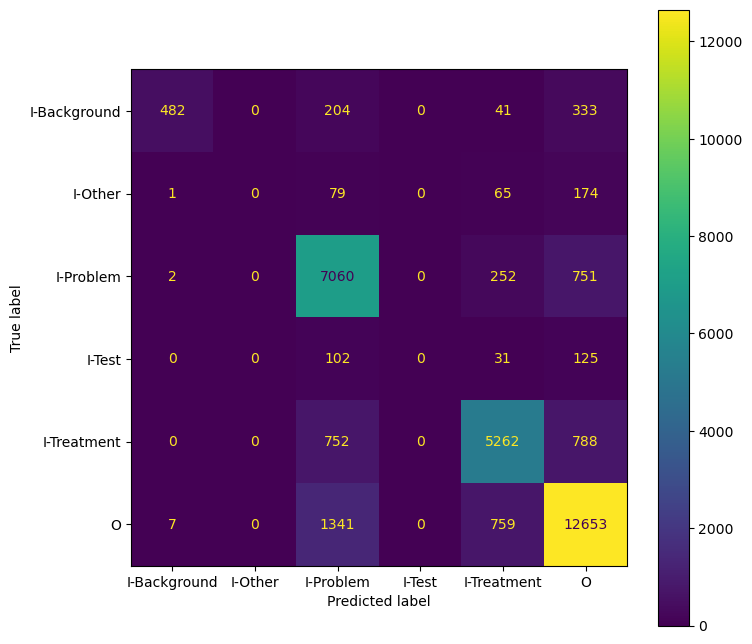

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.980   0.455     0.621   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.740   0.875     0.802   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.821   0.774     0.797   6802.000
O                 0.854   0.857     0.855  14760.000
accuracy          0.814   0.814     0.814      0.814
macro avg         0.566   0.493     0.513  31264.000
weighted avg      0.806   0.814     0.805  31264.000
macro_wo_O        0.508   0.421     0.444  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.980   0.486     0.650    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.702   0.811     0.753   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.765   0.670     0.714   2875.000
O                 0.867   0.916     0.891  13463.000
accuracy  

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

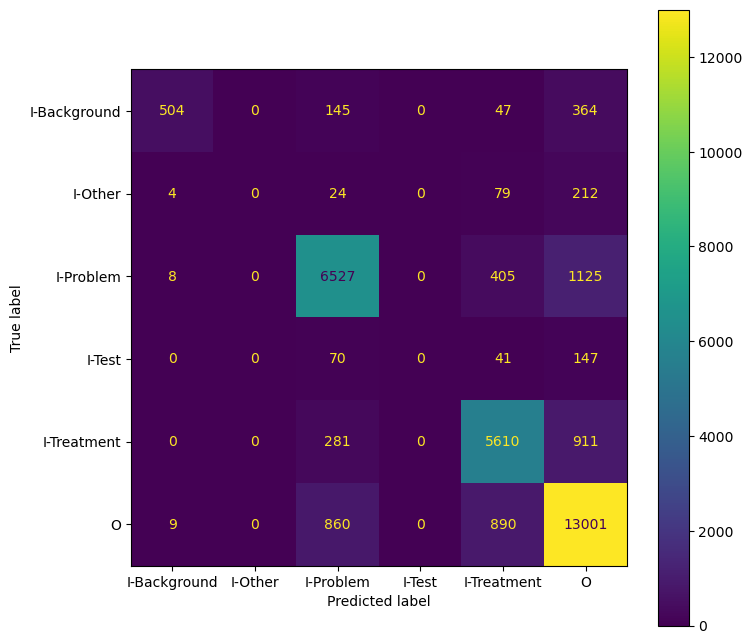

TOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.960   0.475     0.636   1060.00
I-Other           0.000   0.000     0.000    319.00
I-Problem         0.825   0.809     0.817   8065.00
I-Test            0.000   0.000     0.000    258.00
I-Treatment       0.793   0.825     0.809   6802.00
O                 0.825   0.881     0.852  14760.00
accuracy          0.820   0.820     0.820      0.82
macro avg         0.567   0.498     0.519  31264.00
weighted avg      0.808   0.820     0.811  31264.00
macro_wo_O        0.516   0.422     0.452  16504.00
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.963   0.509     0.666    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.795   0.729     0.761   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.732   0.719     0.726   2875.000
O                 0.847   0.933     0.888  13463.000
accuracy          0.8

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

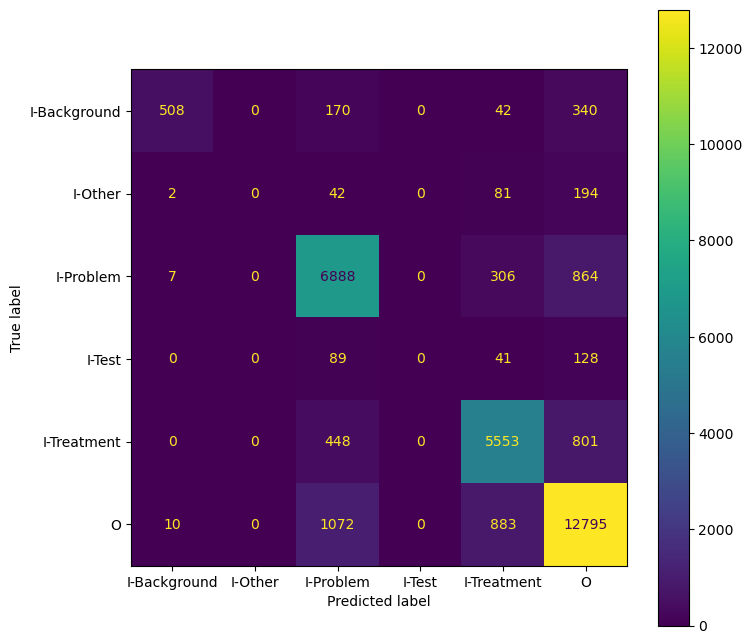

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.964   0.479     0.640   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.791   0.854     0.821   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.804   0.816     0.810   6802.000
O                 0.846   0.867     0.856  14760.000
accuracy          0.823   0.823     0.823      0.823
macro avg         0.568   0.503     0.521  31264.000
weighted avg      0.811   0.823     0.814  31264.000
macro_wo_O        0.512   0.430     0.454  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.967   0.513     0.670    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.758   0.785     0.772   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.743   0.717     0.730   2875.00
O                 0.862   0.923     0.891  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

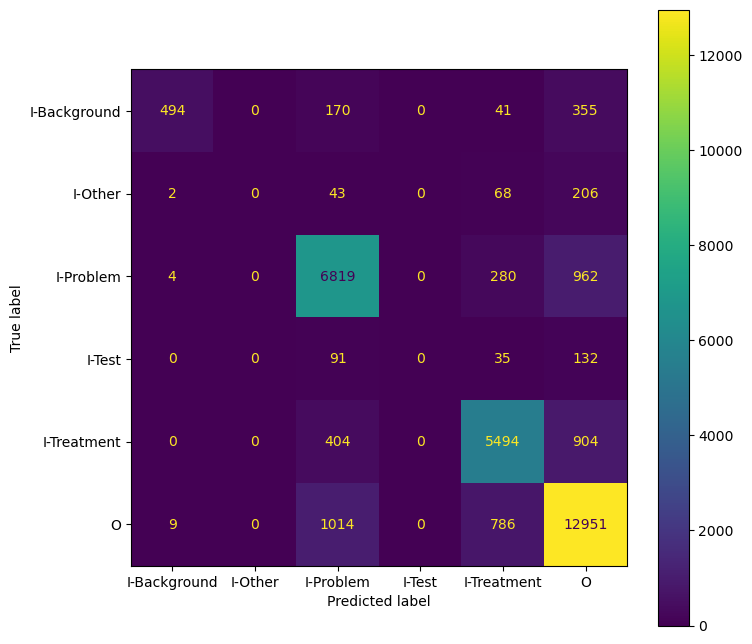

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.971   0.466     0.630   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.798   0.846     0.821   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.820   0.808     0.814   6802.000
O                 0.835   0.877     0.856  14760.000
accuracy          0.824   0.824     0.824      0.824
macro avg         0.571   0.499     0.520  31264.000
weighted avg      0.811   0.824     0.814  31264.000
macro_wo_O        0.518   0.424     0.453  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score   support
I-Background      0.972   0.498     0.659    985.00
I-Other           0.000   0.000     0.000    317.00
I-Problem         0.766   0.772     0.769   3950.00
I-Test            0.000   0.000     0.000    205.00
I-Treatment       0.762   0.702     0.731   2875.00
O                 0.854   0.930     0.890  13463.00
accuracy         

/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/modules/rnn.py:769: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484657607/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/ozan/.conda/envs/medh/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pred

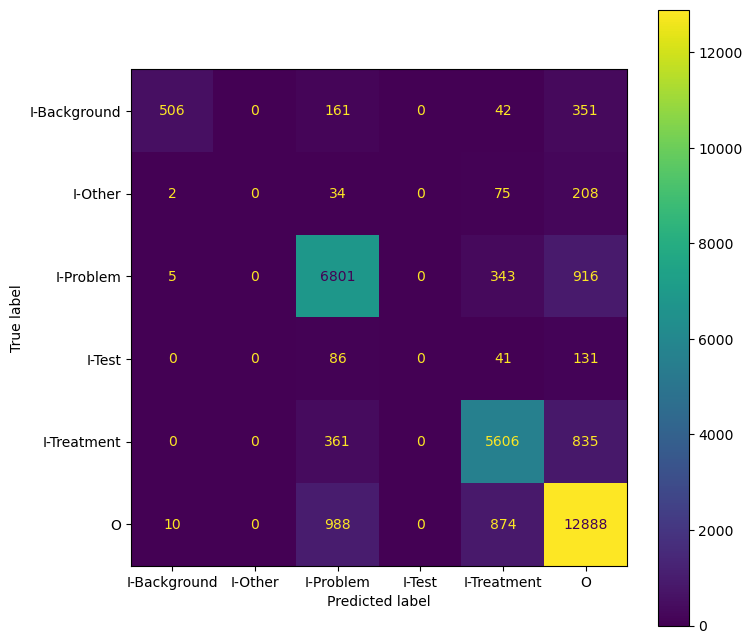

TOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.967   0.477     0.639   1060.000
I-Other           0.000   0.000     0.000    319.000
I-Problem         0.807   0.843     0.825   8065.000
I-Test            0.000   0.000     0.000    258.000
I-Treatment       0.803   0.824     0.813   6802.000
O                 0.841   0.873     0.857  14760.000
accuracy          0.825   0.825     0.825      0.825
macro avg         0.570   0.503     0.522  31264.000
weighted avg      0.813   0.825     0.816  31264.000
macro_wo_O        0.515   0.429     0.455  16504.000
UNTOKENIZED REPORT
              precision  recall  f1-score    support
I-Background      0.971   0.511     0.669    985.000
I-Other           0.000   0.000     0.000    317.000
I-Problem         0.773   0.774     0.773   3950.000
I-Test            0.000   0.000     0.000    205.000
I-Treatment       0.745   0.721     0.733   2875.000
O                 0.858   0.927     0.891  13463.000
accuracy  

TrainOutput(global_step=4640, training_loss=0.755986345225367, metrics={'train_runtime': 1218.4138, 'train_samples_per_second': 30.458, 'train_steps_per_second': 3.808, 'total_flos': 1068155154801576.0, 'train_loss': 0.755986345225367, 'epoch': 10.0})

In [24]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments
from transformers import BertModel, BertConfig
# from torchcrf import CRF

class CustomBertLSTMModel(BertModel):  # (832x50 and 768x13)
    def __init__(self, config):
        super().__init__(config)   
        self.lstm = nn.LSTM(input_size=config.hidden_size, hidden_size=50, num_layers=2, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(50*2, config.num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = super().forward(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        lstm_out, _ = self.lstm(sequence_output)
        logits = self.classifier(lstm_out)

        # Calculate the loss if labels are provided
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 6), labels.view(-1))
        else:
            loss = None

        return (loss, logits) if loss is not None else logits

config = BertConfig.from_pretrained('samrawal/bert-base-uncased_clinical-ner', num_labels=6)
lstm_model = CustomBertLSTMModel(config)


# Training arguments
lstm_training_args = TrainingArguments(
    output_dir='./lstm',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    overwrite_output_dir=True,
    learning_rate=1e-5,
    load_best_model_at_end=False,
)

# Trainer
lstm_trainer = Trainer(
    model=lstm_model,
    args=lstm_training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# Train the model
lstm_trainer.train()
